In [66]:
# A fem common imports.
# Most other imports are done just prior to being used.

import os
from collections import defaultdict
from copy import deepcopy
from datetime import datetime

import matplotlib as mpl
import numpy as np
from scipy.interpolate import interp1d

from util import print_i

In [67]:
from model.bridge.bridge_705 import bridge_705_3d, bridge_705_med_config

c = bridge_705_med_config(bridge_705_3d)
# Set the directory where to save/load responses.
c.root_generated_data_dir = os.path.join("/Users/jeremy/Desktop/mesh-med-600", c.root_generated_data_dir)

INFO: Loaded vehicle data from data/a16-data/a16.csv in 0.14s
WARN: Vehicle PDF sums to 6.3, adjusted to sum to 1


In [68]:
from model.bridge import Point

point_a = Point(x=34.955, y=0, z=29.226 - 16.6)

# Annual temperature
A plot of the annual temperature, which will have to be accounted for in damage detection.

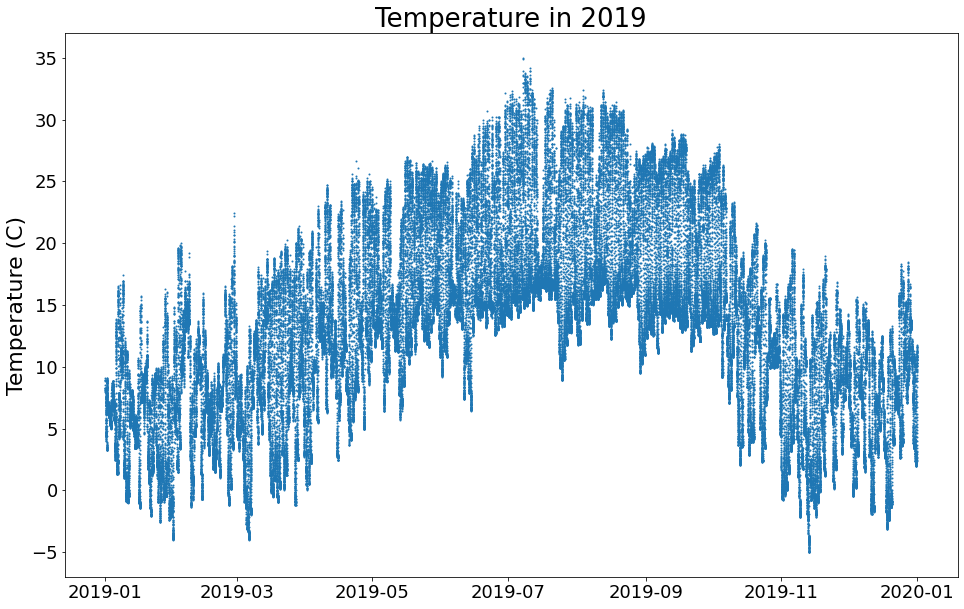

In [69]:
from classify import temperature
from model.response import ResponseType
from plot import plt
from util import resize_units

# Short aliases for response types.
rt_y = ResponseType.YTranslation
rt_s = ResponseType.Strain

# Create functions to resize, and unit strings, for each response type.
resize_y, units_y = resize_units(rt_y.units())
resize_s, _ = resize_units(rt_s.units())

temps_year = temperature.load("holly-springs")
tmin, tmax = min(temps_year["temp"]), max(temps_year["temp"])
new_tmin, new_tmax = -5, 35  # Maximum and minimum temperatures.
temps_year["temp"] = interp1d(np.linspace(tmin, tmax, 1000), np.linspace(new_tmin, new_tmax, 1000))(temps_year["temp"])
effect_year = temperature.effect(c=c, response_type=rt_y, points=[point_a], temps=temps_year["temp"])
effect_year = resize_y(effect_year)

def plot_temp_year():
    plt.scatter(temps_year["datetime"], temps_year["temp"], s=1)
    plt.ylabel("Temperature (C)")
#     ax = plt.twinx()
#     ax.scatter(temps_year["datetime"], effect_year, s=1, alpha=0)
#     plt.ylim(plt.ylim()[1], plt.ylim()[0])
#     plt.ylabel(f"{rt_y.name()} ({units_y})")
    plt.title(f"Temperature in 2019")
    
plt.landscape()
plot_temp_year()

# 2 week temperature
Zooming in a little bit, to show the daily fluctuation in temperature, and how it can change over a number of days.

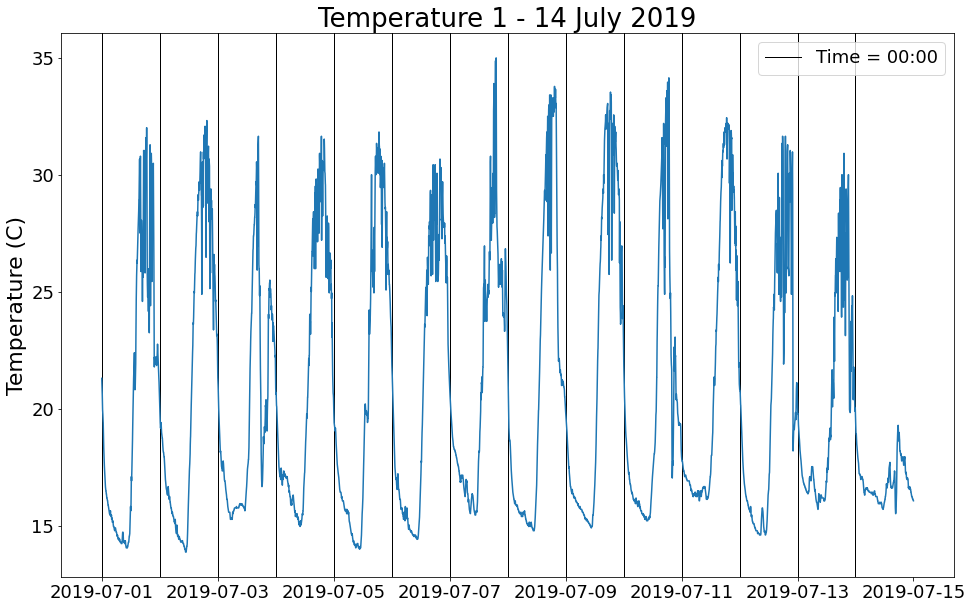

In [70]:
from plot.temperature import plot_day_lines

from_ = datetime.fromisoformat(f"2019-07-01T00:00")
to = datetime.fromisoformat(f"2019-07-14T23:59")
temps_month = temperature.from_to_mins(temps_year, from_, to)
effect_month = temperature.effect(c=c, response_type=rt_y, points=[point_a], temps=temps_month["temp"])
effect_month = resize_y(effect_month)

def plot_temp_two_weeks():
    plot_day_lines(temps_month["datetime"])
    plt.plot(temps_month["datetime"], temps_month["temp"])
    plt.ylabel("Temperature (C)")
    plt.legend(loc="upper right")
#     ax = plt.twinx()
#     ax.scatter(temps_month["datetime"], effect_month, s=1, alpha=0)
#     plt.ylim(plt.ylim()[1], plt.ylim()[0])
#     plt.ylabel(f"{rt_y.name()} ({units_y})")
    plt.title(f"Temperature 1 - 14 July 2019")

plt.landscape()
plot_temp_two_weeks()

# Daily temperature
Damage detection will be done on sensor responses over a shorter period of time. The next plot shows such changes.

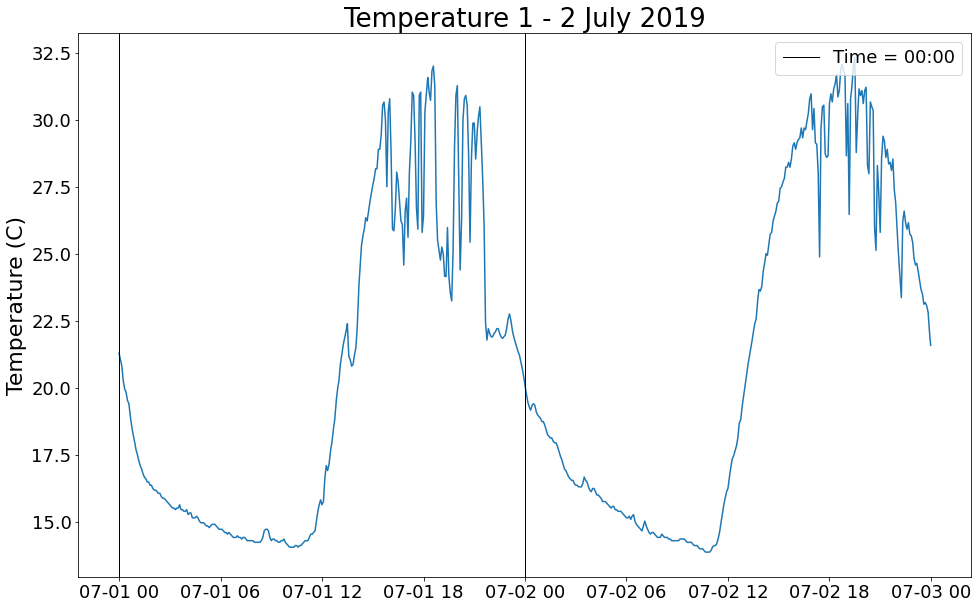

In [71]:
from_ = datetime.fromisoformat(f"2019-07-01T00:00")
to = datetime.fromisoformat(f"2019-07-02T23:59")
temps_days = temperature.from_to_mins(temps_year, from_, to)
effect_days = temperature.effect(c=c, response_type=rt_y, points=[point_a], temps=temps_days["temp"])
effect_days = resize_y(effect_days)

def plot_temp_days():
    plt.plot(temps_days["datetime"], temps_days["temp"])
    plot_day_lines(temps_days["datetime"])
    plt.ylabel("Temperature (C)")
    plt.legend(loc="upper right")
#     ax = plt.twinx()
#     ax.scatter(temps_days["datetime"], effect_days, s=1, alpha=0)
#     plt.ylim(plt.ylim()[1], plt.ylim()[0])
#     plt.ylabel(f"{rt_y.name()} ({units_y})")
    plt.title(f"Temperature 1 - 2 July 2019")
    
plt.landscape()
plot_temp_days()

# Thesis temperature plot
Putting the three plots together for one concise plot for the thesis.

INFO: Saving image to ./writing/thesis/saved-images/temperature.pdf


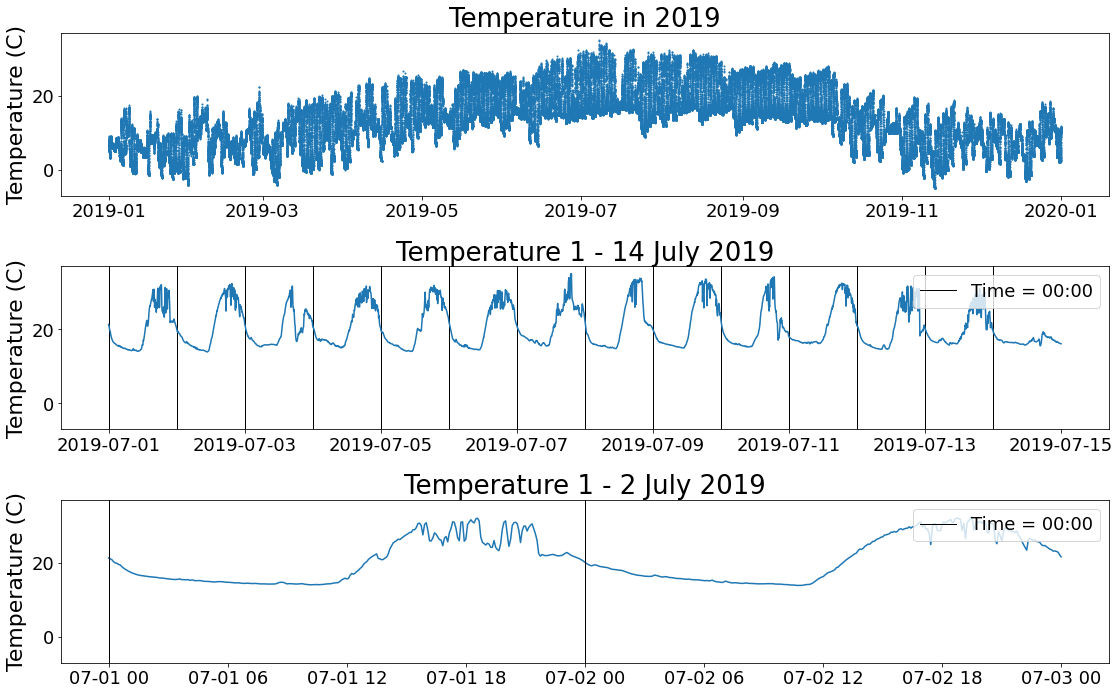

In [72]:
plt.landscape()
ax0 = plt.subplot2grid((3, 3), (1, 0), colspan=3)
plot_temp_two_weeks()
ax1 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
plot_temp_days()
ax2 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
plot_temp_year()

ymin, ymax = np.inf, -np.inf
for ax in [ax0, ax1, ax2]:
    if ax.get_ylim()[0] < ymin:
        ymin = ax.get_ylim()[0]
    if plt.ylim()[1] > ymax:
        ymax = ax.get_ylim()[1]
for ax in [ax0, ax1, ax2]:
    ax.set_ylim((ymin, ymax))
    
plt.tight_layout()
plt.savefig("./writing/thesis/saved-images/temperature.pdf")
plt.show()

# Traffic
48 minutes of traffic data is used for damage detection. Temperature will be sped up such that 48 hours of temperature change takes place over the 48 minutes of traffic simulation.

In [73]:
from classify.data.traffic import load_traffic
from classify.scenario.traffic import normal_traffic

total_mins = 48
total_seconds = total_mins * 60

# Create the traffic.
traffic_scenario = normal_traffic(c=c, lam=5, min_d=2)
traffic_sequence, traffic, traffic_array = load_traffic(
    c=c,
    traffic_scenario=traffic_scenario,
    max_time=total_seconds,
)
traffic_array.shape

/Users/jeremy/Desktop/mesh-med-600/generated-data/bridge-705-3d/healthy/traffic/normal-lam-5-600-2880-0,01.npy


(288001, 2400)

# Collecting responses
Responses are collected here over two damage scenarios (healthy, pier 5 settlement @ 0.5 mm) for the 48 minutes of traffic simulation, at a single sensor. These strains and vertical translation will allow us to see what the traffic signal looks like and how the data distributions are different under each damage scenario.

In [74]:
from fem.run.opensees import OSRunner
from classify.data.responses import responses_to_traffic_array
from classify.scenario.bridge import healthy_damage, pier_disp_damage

damage_scenarios = [healthy_damage, pier_disp_damage([(5, 1 / 1000)])]
response_types = [rt_y, rt_s]
sensor_point = Point(x=21, y=0, z=-8.4)  # Sensor point to investigate.

responses = [[[] for _ in response_types] for _ in damage_scenarios]
for d_i, damage_scenario in enumerate(damage_scenarios):
    for r_i, response_type in enumerate(response_types):
        responses[d_i][r_i] = responses_to_traffic_array(
            c=c,
            traffic_array=traffic_array,
            response_type=response_type,
            damage_scenario=damage_scenario,
            points=[sensor_point],
            sim_runner=OSRunner(c),
        ).T[0]  # Responses from a single point.
responses = np.array(responses)
responses.shape

(288001, 2400)
(2400, 1)
(288001, 2400)
(2400, 1)
(288001, 2400)
(2400, 1)
(288001, 2400)uilt FEMResponses in 0.01s, (ResponseType.YTranslation)
(2400, 1)


(2, 2, 288001)

# Example of traffic responses
The vertical translation and strain responses from the healthy bridge and under pier settlement, at the same point, are compared to get an idea of what the signal due to traffic looks like. At this sensor the vertical translation and strain responses are highly correlated, 0.96. It is hypothesized that the correlation will be different at different positions across the bridge deck.

/Users/jeremy/.local/share/virtualenvs/bridge-dss-jupQo_Ui/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/jeremy/.local/share/virtualenvs/bridge-dss-jupQo_Ui/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(-0.962149275420318, 0.0)
(-0.9621492754203181, 0.0)


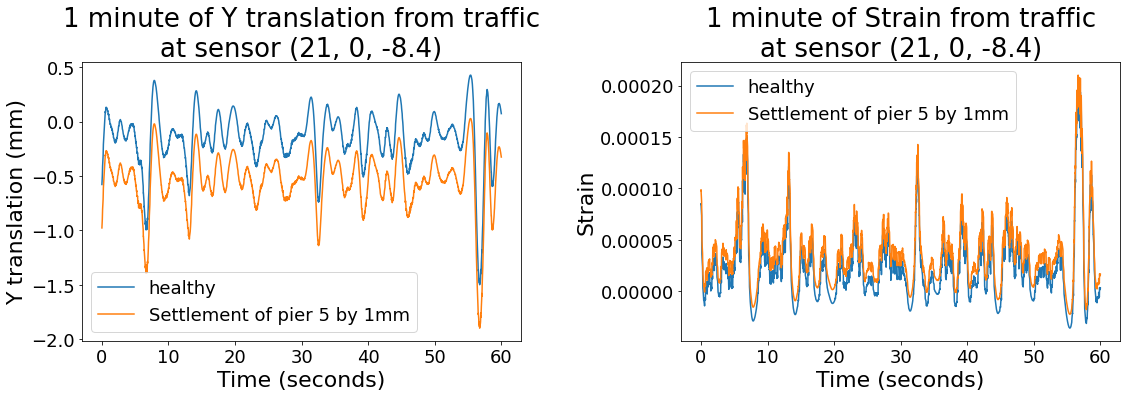

In [75]:
from scipy.stats import pearsonr

y_h, s_h = deepcopy(responses[0])  # Healthy bridge. Vertical translation and strain.
y_p, s_p = deepcopy(responses[1])  # Pier settlement. Vertical translation and strain.
# Cut to 1 minute.
y_h, s_h = y_h[:int(len(y_h) / total_mins)], s_h[:int(len(s_h) / total_mins)]
y_p, s_p = y_p[:int(len(y_p) / total_mins)], s_p[:int(len(s_p) / total_mins)]
# Resize units.
y_h, s_h = resize_y(y_h), resize_s(s_h)
y_p, s_p = resize_y(y_p), resize_s(s_p)

plt.subplot(2, 2, 1) 
plt.plot(np.arange(len(y_h)) * c.sensor_hz, y_h, label="healthy")
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel(f"Time (seconds)")
plt.title(f"1 minute of {rt_y.name()} from traffic\nat sensor {sensor_point}")
plt.subplot(2, 2, 2)
plt.plot(np.arange(len(s_h)) * c.sensor_hz, s_h, label="healthy")
plt.ylabel(f"{rt_s.name()}")
plt.xlabel(f"Time (seconds)")
plt.title(f"1 minute of {rt_s.name()} from traffic\nat sensor {sensor_point}")
plt.subplot(2, 2, 1)
plt.plot(np.arange(len(y_p)) * c.sensor_hz, y_p, label="Settlement of pier 5 by 1mm")
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(np.arange(len(s_p)) * c.sensor_hz, s_p, label="Settlement of pier 5 by 1mm")
plt.legend()
plt.tight_layout()

print(pearsonr(y_h, s_h))
print(pearsonr(y_p, s_p))

# Example of thermal responses
It is also useful to get an idea of what the effect of temperature is like. The responses due to temperature are clearly greater than the traffic responses.  The vertical translation and strain responses due to temperature are entirely correlated, this will possible change once the temperature model modifies the linear temperature component throughout the day, meeting this week to get an idea of approximate values.

In [76]:
temp_effect_y = temperature.get_effect(
    c=c,
    response_type=rt_y,
    points=[sensor_point],
    temps=temps_month["temp"],
    responses=[responses[0][0]],
    # Traffic data is sampled per minute. Here sped up by x60.
    # Since the given data is 48 minutes of traffic, this
    # results in 48 hours of temperature data.
    speed_up=60,
)[0]  # Responses from a single point.
temp_effect_s = temperature.get_effect(
    c=c,
    response_type=rt_s,
    points=[sensor_point],
    temps=temps_month["temp"],
    responses=[responses[0][0]],
    speed_up=60,
)[0]  # Responses from a single point.
temp_effect_y.shape

(288001,)

(1.0, 0.0)

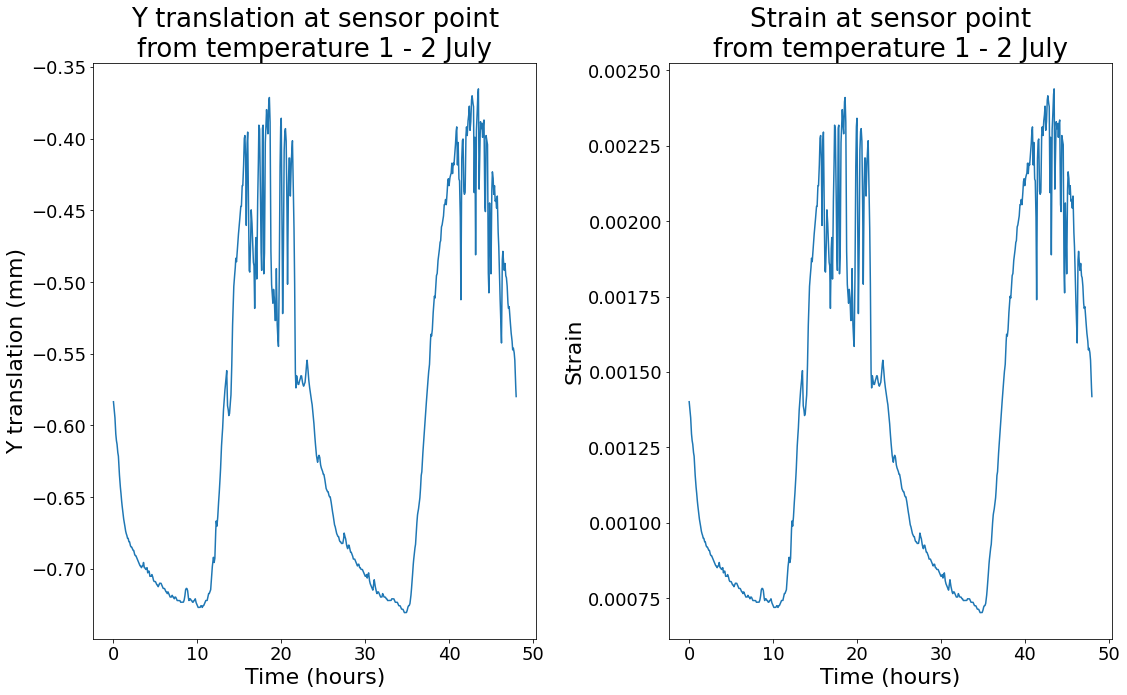

In [77]:
x = np.arange(len(responses[0][0])) * c.sensor_hz / 60
plt.subplot(1, 2, 1)
plt.plot(x, resize_y(temp_effect_y))
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel("Time (hours)")
plt.title(f"{rt_y.name()} at sensor point\nfrom temperature 1 - 2 July")
plt.subplot(1, 2, 2)
plt.plot(x, resize_s(temp_effect_s))
plt.ylabel(f"{rt_s.name()}")
plt.xlabel("Time (hours)")
plt.title(f"{rt_s.name()} at sensor point\nfrom temperature 1 - 2 July")
plt.tight_layout()

pearsonr(temp_effect_y, temp_effect_s)

# Clustering without noise
A previous image showed how the responses change between damaged and undamaged scenarios. Here we attempt clustering of the data without noise, to show what is possible if noise were perfectly removed.

In [78]:
# First collect and label the responses.
damage_features = []  # Dimensions: ((damage scenarios x samples per simulation) x features).
damage_labels = []  # A list of length (damage scenarios x samples per simulation), each value is the damage scenario index.
for damage_i in range(len(responses)):
    y, s = responses[damage_i]
    y, s = resize_y(y), resize_s(s)
    for response_i in range(len(y)):
        damage_features.append([y[response_i], s[response_i]])
        damage_labels.append(damage_i)
damage_features = np.array(damage_features)
damage_labels = np.array(damage_labels)
print(damage_features.shape)
print(damage_labels.shape)

# Downsample from 100 to 1 Hz.
downsample = int(100 / 1)
damage_features, damage_labels = damage_features[::downsample], damage_labels[::downsample]

(576002, 2)
(576002,)


{1, -1}
INFO: k = 0: 2881 / 2881 = 1.0
INFO: k = 1: 2709 / 2880 = 0.940625


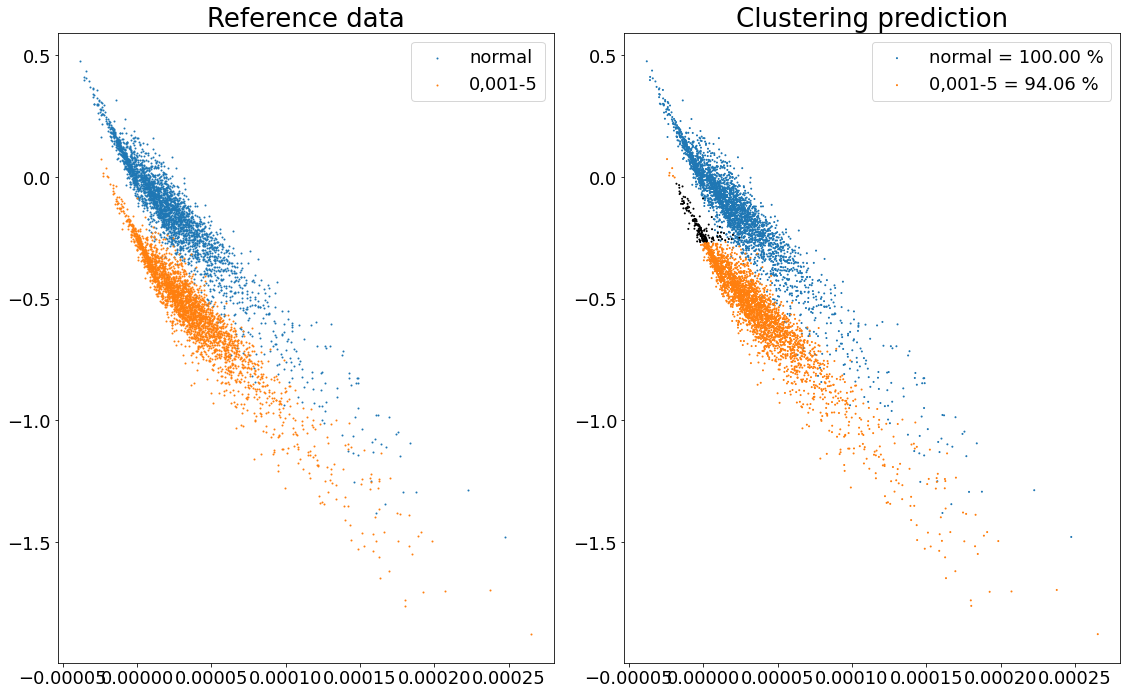

In [85]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, SpectralClustering

from classify.util import flip


def filter_for_label(data, damage_scenario_label, labels):
    """Filter data for a given damage scenario label."""
    return np.array([
        data[i] for i in range(len(data))
        if labels[i] == damage_scenario_label
    ])


def colour(damage_label):
    """Deterministic mapping of integer to colour."""
    return {
        0: "tab:blue",
        1: "tab:orange",
        2: "tab:green",
        3: "tab:red",
    }[damage_label]


# Plot the reference data.
plt.subplot(1, 2, 1)
for damage_label in set(damage_labels):
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plt.scatter(plot_features[:, 1], plot_features[:, 0], label=damage_scenarios[damage_label].name, s=1)
plt.title("Reference data")
plt.legend()
    
# Calculate labels with a model.
# model = GaussianMixture(n_components=len(damage_scenarios)).fit(damage_features)
# labels = DBSCAN().fit_predict(damage_features)
# model = KMeans(n_clusters=2).fit(damage_features)
# model = SpectralClustering(2).fit(damage_features)
model = OneClassSVM(gamma='auto').fit(filter_for_label(damage_features, 0, damage_labels))
# labels = flip(l=model.predict(damage_features), ref=damage_labels)
labels = model.predict(damage_features)
print(set(labels))

# Determine accuracy of the model.
total = defaultdict(lambda: 0)
correct = defaultdict(lambda: 0)
for i, label in enumerate(damage_labels):
    total[label] += 1
    if (label == 0 and labels[i] == 1) or labels[i] == -1:
        correct[label] += 1
for k, t in total.items():
    print_i(f"k = {k}: {correct[k]} / {t} = {correct[k] / t}")

# Plot the model results.
plt.subplot(1, 2, 2)
for damage_label in set(damage_labels):
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plot_labels = filter_for_label(labels, damage_label, damage_labels)
    c = [colour(damage_label) if ((damage_label == 0 and l == 1) or l == -1) else "black" for l in plot_labels]
    plt.scatter(plot_features[:, 1], plot_features[:, 0], c=c, label=f"{damage_scenarios[damage_label].name} = {correct[damage_label] / total[damage_label] * 100:.2f} %", s=1)
plt.title("Clustering prediction")
plt.legend()
plt.tight_layout()

# Simulation data with temperature effect
The data on which clustering is done is under the influence of a temperature effect, which we consider as noise. First here is some additional temperature data from December, to contrast with that from July.

Text(0.5, 1.0, 'Temperature effect 30 - 31 December 2019')

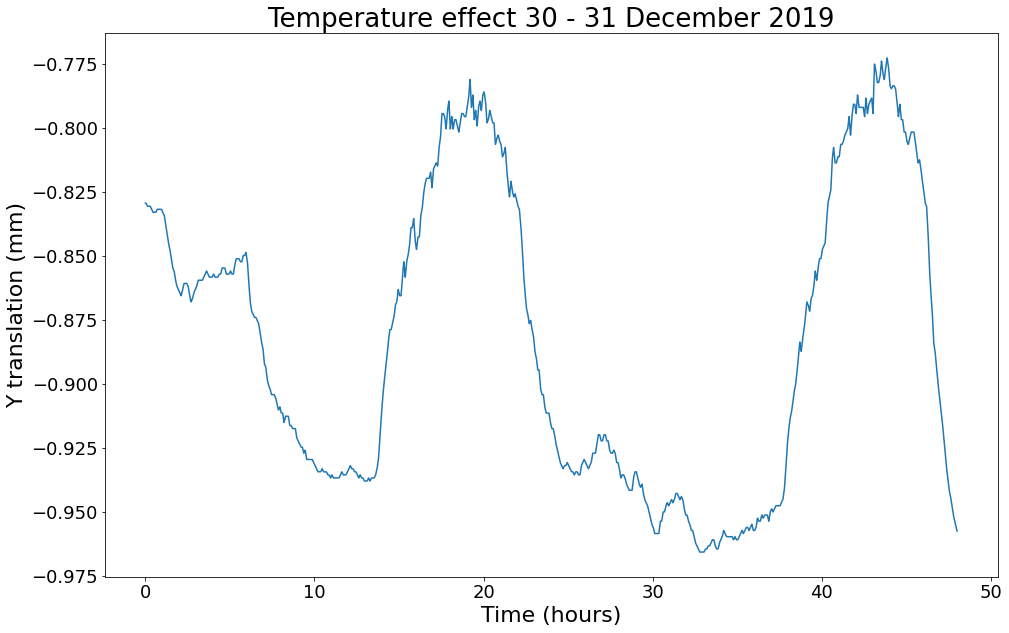

In [15]:
from_ = datetime.fromisoformat(f"2019-12-29T23:58")
to = datetime.fromisoformat(f"2019-12-31T23:59")
temps_days_2 = temperature.from_to_mins(temps_year, from_, to)

temp_effect_y_2 = temperature.get_effect(
    c=c,
    response_type=rt_y,
    points=[sensor_point],
    temps=temps_days_2["temp"],
    responses=[responses[0][0]],
    # Traffic data is sampled per minute. Here sped up by x60.
    # Since the given data is 48 minutes of traffic, this
    # results in 48 hours of temperature data.
    speed_up=60,
)[0]  # Responses from a single point.
temp_effect_s_2 = temperature.get_effect(
    c=c,
    response_type=rt_s,
    points=[sensor_point],
    temps=temps_days_2["temp"],
    responses=[responses[0][0]],
    speed_up=60,
)[0]  # Responses from a single point.
temp_effect_y_2.shape

x = np.arange(len(responses[0][0])) * c.sensor_hz / 60
plt.plot(x, resize_y(temp_effect_y_2))
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel("Time (hours)")
plt.title(f"Temperature effect 30 - 31 December 2019")

# Simulation data with temperature effect
Combining each of the temperature effects (July and December) and each of the damage scenarios (healthy and settled pier) the question is can pier settlement be detected while not detecting the change due to the change in seasons.

/Users/jeremy/.local/share/virtualenvs/bridge-dss-jupQo_Ui/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/jeremy/.local/share/virtualenvs/bridge-dss-jupQo_Ui/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


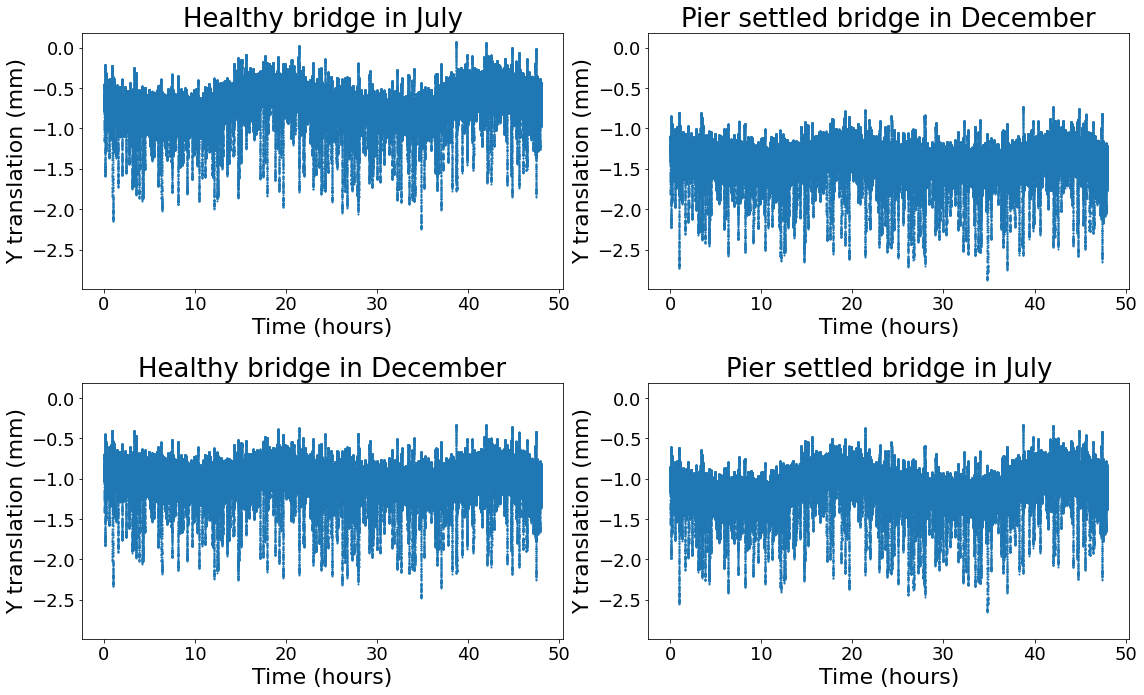

In [16]:
y_h, s_h = deepcopy(responses[0])  # Healthy bridge. Vertical translation and strain.
y_p, s_p = deepcopy(responses[1])  # Pier settlement. Vertical translation and strain.

plt.subplot(2, 2, 1)
plt.scatter(x, resize_y(y_h + temp_effect_y), s=1, label="total effect")
# plt.plot(x, resize_y(temp_effect_y), label="temperature effect", color="tab:orange")
# plt.legend()
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel("Time (hours)")
plt.title("Healthy bridge in July")
plt.subplot(2, 2, 3)
plt.scatter(x, resize_y(y_h + temp_effect_y_2), s=1, label="total effect")
# plt.plot(x, resize_y(temp_effect_y_2), label="temperature effect", color="tab:orange")
# plt.legend()
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel("Time (hours)")
plt.title("Healthy bridge in December")
plt.subplot(2, 2, 4)
plt.scatter(x, resize_y(y_p + temp_effect_y), s=1, label="total effect")
# plt.plot(x, resize_y(temp_effect_y), label="temperature effect", color="tab:orange")
# plt.legend()
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel("Time (hours)")
plt.title("Pier settled bridge in July")
plt.subplot(2, 2, 2)
plt.scatter(x, resize_y(y_p + temp_effect_y_2), s=1, label="total effect")
# plt.plot(x, resize_y(temp_effect_y_2), label="temperature effect", color="tab:orange")
# plt.legend()
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel("Time (hours)")
plt.title("Pier settled bridge in December")

ymin, ymax = np.inf, -np.inf
for p in range(1, 4 + 1):
    plt.subplot(2, 2, p)
    if plt.ylim()[0] < ymin:
        ymin = plt.ylim()[0]
    if plt.ylim()[1] > ymax:
        ymax = plt.ylim()[1]
for p in range(1, 4 + 1):
    plt.subplot(2, 2, p)
    plt.ylim((ymin, ymax))
    
plt.tight_layout()

# Clustering with temperature effect
Clustering the first minute of data from each of the four scenarios above.

In [43]:
data_and_names = [
    (y_h + temp_effect_y, s_h + temp_effect_s, "Healthy bridge in July"),
    (y_h + temp_effect_y_2, s_h + temp_effect_s_2, "Healthy bridge in December"),
    (y_p + temp_effect_y, s_p + temp_effect_s, "Pier settled bridge in July"),
    (y_p + temp_effect_y_2, s_p + temp_effect_s_2, "Pier settled bridge in December"),
]
damage_names = list(map(lambda x: x[2], data_and_names))

# First collect and label the responses.
damage_features = []  # Dimensions: ((scenarios x samples per simulation) x features).
damage_labels = []  # A list of length (scenarios x samples per simulation), each value is the damage scenario index.
for label_i, (y, s, _name) in enumerate(data_and_names):
    y, s = resize_y(y), resize_s(s)
    for response_i in range(len(y)):
        damage_features.append([y[response_i], s[response_i]])
        damage_labels.append(label_i)
damage_features = np.array(damage_features)
damage_labels = np.array(damage_labels)
print(damage_features.shape)
print(damage_labels.shape)
print(set(damage_labels))

# Downsample from 100 to 1 Hz.
downsample = int(100 / 1)
damage_features, damage_labels = damage_features[::downsample], damage_labels[::downsample]

(1152004, 2)
(1152004,)
{0, 1, 2, 3}


{1, -1}
INFO: k = 0: 2881 / 2881 = 1.0
INFO: k = 1: 2185 / 2880 = 0.7586805555555556
INFO: k = 2: 2494 / 2880 = 0.8659722222222223
INFO: k = 3: 2873 / 2880 = 0.9975694444444444


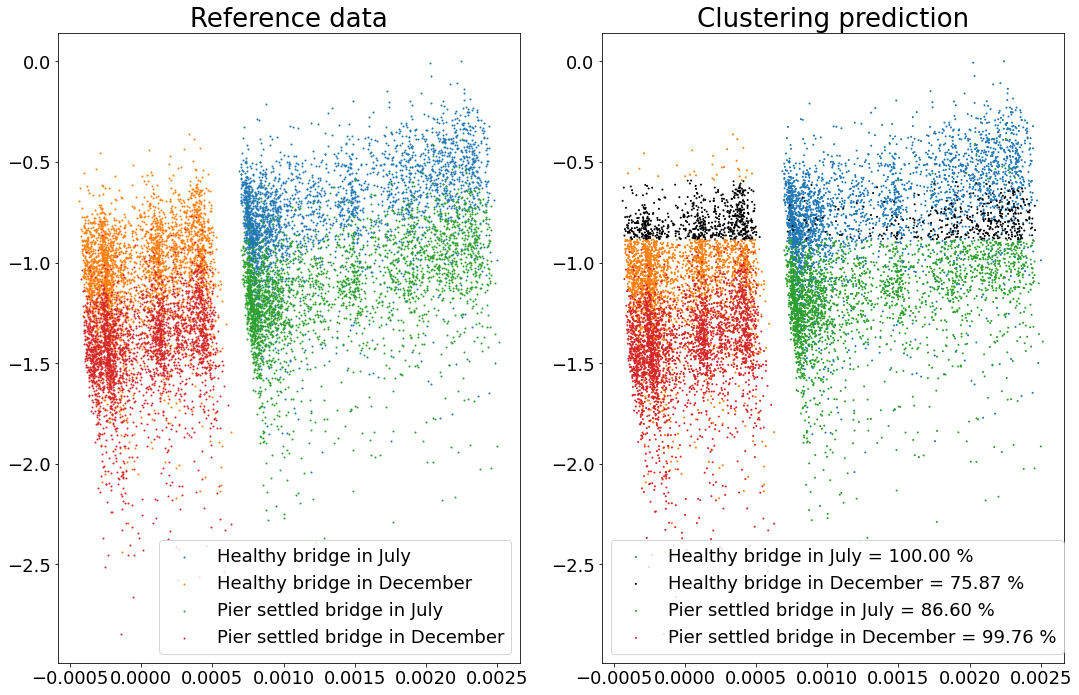

In [58]:
from sklearn.svm import OneClassSVM

# Plot the reference data.
plt.subplot(1, 2, 1)
for damage_label in set(damage_labels):
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plt.scatter(plot_features[:, 1], plot_features[:, 0], label=damage_names[damage_label], s=1)
plt.title("Reference data")
plt.legend()

# Calculate labels with a model.
# model = KMeans(n_clusters=len(data_and_labels)).fit(damage_features)
model = OneClassSVM(gamma='auto').fit(filter_for_label(damage_features, 0, damage_labels))
# labels = flip(l=model.predict(damage_features), ref=damage_labels)
labels = model.predict(damage_features)
print(set(labels))

# # Determine accuracy of the model.
total = defaultdict(lambda: 0)
correct = defaultdict(lambda: 0)
for i, label in enumerate(damage_labels):
    total[label] += 1
#     print(label, labels[i])
    if (label == 0 and labels[i] == 1) or labels[i] == -1:
        correct[label] += 1
for k, t in total.items():
    print_i(f"k = {k}: {correct[k]} / {t} = {correct[k] / t}")

# Plot the model results.
plt.subplot(1, 2, 2)
for damage_label in set(damage_labels):
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plot_labels = filter_for_label(labels, damage_label, damage_labels)
    c = [colour(damage_label) if ((damage_label == 0 and l == 1) or l == -1) else "black" for l in plot_labels]
    plt.scatter(plot_features[:, 1], plot_features[:, 0], c=c, label=f"{damage_names[damage_label]} = {correct[damage_label] / total[damage_label] * 100:.2f} %", s=1)
plt.title("Clustering prediction")
plt.legend()
plt.tight_layout()